<a href="https://colab.research.google.com/github/edwinsoftwaredev/ai-notebooks/blob/main/cats_dogs_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install wandb
!pip install "ray[tune]"
!pip install "dask[complete]"

from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("WANDB_API_KEY")

import wandb
wandb.login(key=secret_value_0)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.9 MB/s eta 0:00:0000:010:01


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: edwinsoftwaredev (edwinsoftwaredev-personal) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
import os
import tempfile

import io
from PIL import Image

import torch
from torchvision.transforms import v2
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch import nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import ray
from ray import train, tune
from ray.tune.schedulers import ASHAScheduler

import dask

In [ ]:
train_transforms = v2.Compose([
    v2.PILToTensor(),
    v2.RandomHorizontalFlip(p=0.5),
    v2.Resize(224),     # TODO: replace with custom function
    v2.CenterCrop(224),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transforms = v2.Compose([
    v2.PILToTensor(),
    v2.Resize(224),
    v2.CenterCrop(224),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
def apply_transforms(img, test_dataset):
    # PIL Image object
    img_pil = Image.open(io.BytesIO(img['bytes']))
    img_pil = img_pil.convert('RGB') # TODO: check dimensions mismatch
    return train_transforms(img_pil) if not test_dataset else test_transforms(img_pil)

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, images, labels, test_dataset):
        self.images = images
        self.labels = labels
        self.test_dataset = test_dataset


    def __len__(self):
        return len(self.labels)


    def __getitem__(self, idx):
        image = self.images.iloc[idx]
        label = self.labels.iloc[idx]

        # Note that for each image this happens
        # on every epoch
        image = apply_transforms(image, self.test_dataset)

        return image, label


In [ ]:
@dask.delayed
def partitions_to_datasets(partition, test_dataset):
    return ImageDataset(partition['image'], partition['labels'], test_dataset)


In [ ]:
import dask.dataframe as dd
import pyarrow as pa

import numpy as np
from random import randint

ddf = dd.read_parquet("hf://datasets/microsoft/cats_vs_dogs/data/train-*.parquet")

ddf.to_parquet('/content/cats_vs_dogs_parquet', schema={ 'image': pa.struct([('bytes', pa.binary()), ('path', pa.string())]), 'labels': pa.int64() })

def add_random_col(df):
    seed = randint(100, 200)
    rng = np.random.RandomState(seed)
    return df.assign(_rand=rng.rand(len(df)))

# Assign a random column in each partition with a different seed
ddf = ddf.map_partitions(add_random_col)

ddf = ddf.shuffle(ddf.columns[2], ignore_index=True)

ddf.visualize()

ddf.to_parquet('/content/cats_vs_dogs_parquet', schema={ 'image': pa.struct([('bytes', pa.binary()), ('path', pa.string())]), 'labels': pa.int64() })

ddf = dd.read_parquet('/content/cats_vs_dogs_parquet')

ddf = ddf.random_split([0.8, 0.2], random_state=123, shuffle=True)

train_set, test_set = ddf

train_datasets = [partitions_to_datasets(partition, False) for partition in train_set.to_delayed()]
test_datasets = [partitions_to_datasets(partition, True) for partition in test_set.to_delayed()]

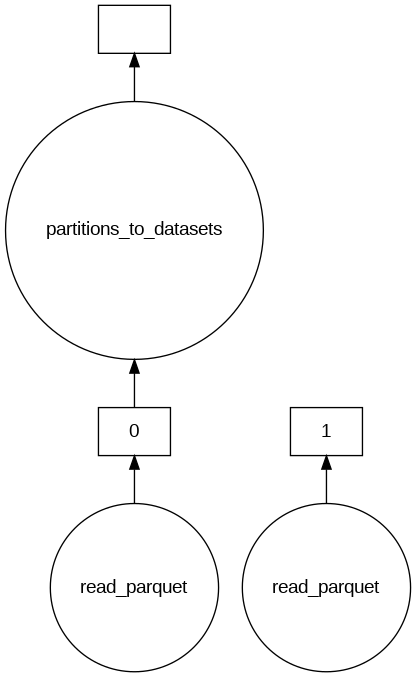

In [ ]:
train_datasets[0].visualize()

In [ ]:
class CNN(nn.Module):
    def __init__(
            self,
            l1_c,
            l1_cnk,
            l1_pk,
            l1_ps,
            l2_c,
            l2_cnk,
            l2_pk,
            l2_ps,
            l3_c,
            l3_cnk,
            l3_pk,
            l3_ps,
            l4_c,
            l4_cnk,
            l4_pk,
            l4_ps,
            l5_c,
            l5_cnk,
            l5_pk,
            l5_ps,
        ):

        super().__init__()

        self.cnn = nn.Sequential(
            # l1
            nn.Conv2d(3, l1_c, l1_cnk, bias=False),
            nn.BatchNorm2d(l1_c, affine=True),
            nn.LeakyReLU(),
            nn.MaxPool2d(l1_pk, stride=l1_ps),

            # l2
            nn.Conv2d(l1_c, l2_c, l2_cnk),
            nn.LeakyReLU(),
            nn.MaxPool2d(l2_pk, stride=l2_ps),

            # l3
            nn.Conv2d(l2_c, l3_c, l3_cnk),
            nn.LeakyReLU(),
            nn.MaxPool2d(l3_pk, stride=l3_ps),

            # l4
            nn.Conv2d(l3_c, l4_c, l4_cnk),
            nn.LeakyReLU(),
            nn.MaxPool2d(l4_pk, stride=l4_ps),

            # l5
            nn.Conv2d(l4_c, l5_c, l5_cnk),
            nn.LeakyReLU(),
            nn.MaxPool2d(l5_pk, stride=l5_ps),

            # output
            nn.Conv2d(l5_c, 1, 1),     # 1 channel == 1 class == 0-1 probability
            nn.AdaptiveAvgPool2d(1)     # global avg pooling
        )


    def forward(self, images):
        # images: list of image tensors with shape (3, H, W), variable H and W

        outputs = []
        for image in images:
            image = image.unsqueeze(0)                      # (1, 3, H, W) adds dim N (N, C, H, W)
            output = self.cnn(image)                        # (1, 1, 1, 1) -> output layer
            # output = output.view(output.size(0), -1)      # (N, C) or (N, flatten remaining dimensions)
            output = output.view(-1)                        # flatten the whole tensor to match target (y) tensor
            outputs.append(output)


        return torch.cat(outputs, dim=0)


In [ ]:
def train(model: CNN, dataloader: DataLoader, loss_fn, optimizer):
    train_correct = 0
    train_loss = 0

    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X = [x.to(device) for x in X]
        y = torch.tensor(y, device=device, dtype=torch.float)

        output = model(X)

        loss = loss_fn(output, y)

        # backprop
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # check results
        pred_probs = torch.nn.functional.sigmoid(output)
        y_pred = (pred_probs >= 0.5).float()
        correct = (y_pred == y).sum().item()

        train_correct += correct
        train_loss += loss.item()


    return { 'correct': train_correct, 'loss': train_loss }


In [ ]:
def test(model: CNN, dataloader: DataLoader, loss_fn):
    test_correct = 0
    test_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            X = [x.to(device) for x in X]
            y = torch.tensor(y, device=device, dtype=torch.float)

            output = model(X)
            loss = loss_fn(output, y)

            pred_probs = torch.nn.functional.sigmoid(output)
            y_pred = (pred_probs >= 0.5).float()
            correct = (y_pred == y).sum().item()

            test_correct += correct
            test_loss += loss.item()


    return { 'correct': test_correct, 'loss': test_loss }


In [ ]:
def raytune_load_checkpoint(model: CNN, optim: torch.optim.Adam):
    if tune.get_checkpoint():
        loaded_checkpoint = tune.get_checkpoint()
        with loaded_checkpoint.as_directory() as loaded_checkpoint_dir:
            model_state, optim_state = torch.load(os.path.join(loaded_checkpoint_dir, 'checkpoint.pt'))
            model.load_state_dict(model_state)
            optim.load_state_dict(optim_state)


In [ ]:
def raytune_save_checkpoint(model: CNN, optim: torch.optim.Adam, train_metrics, test_metrics):
    with tempfile.TemporaryDirectory() as temp_checkpoint_dir:
        path = os.path.join(temp_checkpoint_dir, 'checkpoint.pt')
        torch.save((model.state_dict(), optim.state_dict()), path)
        checkpoint = tune.Checkpoint.from_directory(temp_checkpoint_dir)
        tune.report({**train_metrics, **test_metrics}, checkpoint=checkpoint)


In [ ]:
from datetime import datetime

def train_model(config):
    lr = config['lr']
    epochs = config['epochs']
    batch_size = config['batch_size']

    model = CNN(
        config['l1_c'],
        config['l1_cnk'],
        config['l1_pk'],
        config['l1_ps'],
        config['l2_c'],
        config['l2_cnk'],
        config['l2_pk'],
        config['l2_ps'],
        config['l3_c'],
        config['l3_cnk'],
        config['l3_pk'],
        config['l3_ps'],
        config['l4_c'],
        config['l4_cnk'],
        config['l4_pk'],
        config['l4_ps'],
        config['l5_c'],
        config['l5_cnk'],
        config['l5_pk'],
        config['l5_ps'],
    )

    model.to(device)

    loss_fn = torch.nn.BCEWithLogitsLoss()
    optim = torch.optim.Adam(model.parameters(), lr=lr)

    wandb.init(project='cats_dogs_classifier', group='experiment_9', config=config)


    raytune_load_checkpoint(model, optim)

    train_metrics = None
    test_metrics = None

    for t in range(epochs):
        train_state = { 'correct': 0, 'loss': 0, 'nbatches': 0, 'dataset_size': 0 }
        test_state = { 'correct': 0, 'loss': 0, 'nbatches': 0, 'dataset_size': 0 }

        start = datetime.now()

        npartitions = train_set.npartitions
        for partition in range(npartitions):

            train_dataloader = DataLoader(
                train_datasets[partition].compute(),
                batch_size=batch_size,
                shuffle=True,
                num_workers=4,
                pin_memory=True,
                # Note that images vary in size and
                # batches are tuples not torch.Tensor
                collate_fn=lambda batch: tuple(zip(*batch))
            )

            test_dataloader = DataLoader(
                test_datasets[partition].compute(),
                batch_size=batch_size,
                shuffle=True,
                num_workers=4,
                pin_memory=True,
                # Note that images vary in size and
                # batches are tuples not torch.Tensor
                collate_fn=lambda batch: tuple(zip(*batch))
            )

            train_metrics = train(model, train_dataloader, loss_fn, optim)
            test_metrics = test(model, test_dataloader, loss_fn)


            train_state['correct'] += train_metrics['correct']
            train_state['loss'] += train_metrics['loss']
            train_state['nbatches'] += len(train_dataloader)
            train_state['dataset_size'] += len(train_dataloader.dataset)

            test_state['correct'] += test_metrics['correct']
            test_state['loss'] += test_metrics['loss']
            test_state['nbatches'] += len(test_dataloader)
            test_state['dataset_size'] += len(test_dataloader.dataset)

        end = datetime.now()

        print(f'epoch {t}, time: {end - start}\n')

        train_correct = train_state['correct'] / train_state['dataset_size']
        train_loss = train_state['loss'] / train_state['nbatches']

        test_correct = test_state['correct'] / test_state['dataset_size']
        test_loss = test_state['loss'] / test_state['nbatches']

        wandb.log({ 'train_accuracy': train_correct, 'train_loss': train_loss, 'epoch': t })
        wandb.log({ 'test_accuracy': test_correct, 'test_loss': test_loss, 'epoch': t })


    raytune_save_checkpoint(
        model,
        optim,
        { 'train_accuracy': train_correct, 'train_loss': train_loss, 'epoch': t },
        { 'test_accuracy': test_correct, 'test_loss': test_loss, 'epoch': t }
    )

    wandb.finish()


In [ ]:
config = {
    'l1_c': tune.choice([32]),
    'l1_cnk': tune.choice([3]),
    'l1_pk': tune.choice([4]),
    'l1_ps': tune.choice([2]),

    'l2_c': tune.choice([32]),
    'l2_cnk': tune.choice([3]),
    'l2_pk': tune.choice([4]),
    'l2_ps': tune.choice([2]),

    'l3_c': tune.choice([32]),
    'l3_cnk': tune.choice([3]),
    'l3_pk': tune.choice([4]),
    'l3_ps': tune.choice([2]),

    'l4_c': tune.choice([32]),
    'l4_cnk': tune.choice([3]),
    'l4_pk': tune.choice([4]),
    'l4_ps': tune.choice([2]),

    'l5_c': tune.choice([64]),
    'l5_cnk': tune.choice([3]),
    'l5_pk': tune.choice([4]),
    'l5_ps': tune.choice([2]),

    'lr': tune.choice([3e-3]),
    'batch_size': tune.choice([64]),
    'epochs': 20,
    'num_trials': 1,
}

scheduler = ASHAScheduler(
    time_attr='training_iteration',
    max_t=config['epochs'],
    grace_period=1,
    reduction_factor=2
)

tuner = tune.Tuner(
    tune.with_resources(
        tune.with_parameters(train_model),
        # resources={}
        resources={ 'cpu': 4, 'gpu': 1, 'accelerator_type:P100': 1 }
    ),

    tune_config=tune.TuneConfig(
        metric='test_loss',
        mode='min',
        scheduler=scheduler,
        num_samples=config['num_trials']
    ),

    param_space=config
)

results = tuner.fit()

best_result = results.get_best_result('test_loss', 'min')

print(f'Best trial config: { best_result.config }')
print(f'Best trial final validation loss: { best_result.metrics["test_loss"] }')
print(f'Best trial final validation accuracy: { best_result.metrics["test_accuracy"] }')

(train_model pid=1178) wandb: Currently logged in as: edwinsoftwaredev (edwinsoftwaredev-personal) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
(train_model pid=1178) wandb: Tracking run with wandb version 0.19.9
(train_model pid=1178) wandb: Run data is saved locally in /tmp/ray/session_2025-06-03_22-15-20_022967_35/artifacts/2025-06-03_22-28-18/train_model_2025-06-03_22-28-18/working_dirs/train_model_0c3f6_00000_0_batch_size=64,l1_c=32,l1_cnk=3,l1_pk=4,l1_ps=2,l2_c=32,l2_cnk=3,l2_pk=4,l2_ps=2,l3_c=32,l3_cnk=3,l3_pk=4_2025-06-03_22-28-18/wandb/run-20250603_222827-kkwpey71
(train_model pid=1178) wandb: Run `wandb offline` to turn off syncing.
(train_model pid=1178) wandb: Syncing run dashing-tree-160
(train_model pid=1178) wandb: ⭐️ View project at https://wandb.ai/edwinsoftwaredev-personal/cats_dogs_classifier
(train_model pid=1178) wandb: 🚀 View run at https://wandb.ai/edwinsoftwaredev-personal/cats_dogs_classifier/runs/kkwpey71


(train_model pid=1178) epoch 0, time: 0:01:44.653771
(train_model pid=1178) 
(train_model pid=1178) epoch 1, time: 0:01:41.328804
(train_model pid=1178) 
(train_model pid=1178) epoch 2, time: 0:01:40.680912
(train_model pid=1178) 
(train_model pid=1178) epoch 3, time: 0:01:38.314224
(train_model pid=1178) 
(train_model pid=1178) epoch 4, time: 0:01:38.378372
(train_model pid=1178) 
(train_model pid=1178) epoch 5, time: 0:01:41.644334
(train_model pid=1178) 
(train_model pid=1178) epoch 6, time: 0:01:40.629215
(train_model pid=1178) 
(train_model pid=1178) epoch 7, time: 0:01:38.884804
(train_model pid=1178) 
(train_model pid=1178) epoch 8, time: 0:01:37.796598
(train_model pid=1178) 
(train_model pid=1178) epoch 9, time: 0:01:36.731932
(train_model pid=1178) 
(train_model pid=1178) epoch 10, time: 0:01:36.299611
(train_model pid=1178) 
(train_model pid=1178) epoch 11, time: 0:01:35.973773
(train_model pid=1178) 
(train_model pid=1178) epoch 12, time: 0:01:35.579545
(train_model pid=117

(train_model pid=1178) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_model_2025-06-03_22-28-18/train_model_0c3f6_00000_0_batch_size=64,l1_c=32,l1_cnk=3,l1_pk=4,l1_ps=2,l2_c=32,l2_cnk=3,l2_pk=4,l2_ps=2,l3_c=32,l3_cnk=3,l3_pk=4_2025-06-03_22-28-18/checkpoint_000000)
(train_model pid=1178) wandb:                                                                                
(train_model pid=1178) wandb: 
(train_model pid=1178) wandb: Run history:
(train_model pid=1178) wandb:          epoch ▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
(train_model pid=1178) wandb:  test_accuracy ▁▄▅▆▆▇▇▇▇▇██████████
(train_model pid=1178) wandb:      test_loss █▆▅▃▄▃▃▂▂▂▂▂▁▁▁▁▂▁▁▁
(train_model pid=1178) wandb: train_accuracy ▁▄▅▆▆▆▇▇▇▇▇▇▇███████
(train_model pid=1178) wandb:     train_loss █▆▅▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
(train_model pid=1178) wandb: 
(train_model pid=1178) wandb: Run summary:
(train_model pid=1178) wandb:          epoch 19
(train_model pid=1178) wandb:  

Best trial config: {'l1_c': 32, 'l1_cnk': 3, 'l1_pk': 4, 'l1_ps': 2, 'l2_c': 32, 'l2_cnk': 3, 'l2_pk': 4, 'l2_ps': 2, 'l3_c': 32, 'l3_cnk': 3, 'l3_pk': 4, 'l3_ps': 2, 'l4_c': 32, 'l4_cnk': 3, 'l4_pk': 4, 'l4_ps': 2, 'l5_c': 64, 'l5_cnk': 3, 'l5_pk': 4, 'l5_ps': 2, 'lr': 0.003, 'batch_size': 64, 'epochs': 20, 'num_trials': 1}
Best trial final validation loss: 0.32003129263446756
Best trial final validation accuracy: 0.866593886462882
